In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob 
import collections
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import random
from tensorboardX import SummaryWriter
from tqdm import tqdm
import torch.nn.functional as F
from sklearn import mixture


In [3]:
emo_map={'angry':0, 'neutral':1,'happy':2, 'sad':3}
spk_list = os.listdir('/mnt/gyzhang/fastspeech2-master/data/raw/TGEmotion/mfa_input')
spk2id = {spk:idx+1 for idx, spk in enumerate(spk_list)}
file_list = glob("/mnt/gyzhang/projects/fastspeech2-master/checkpoints/fs2_hiemo_fb0125_consp_m6/train_generated_162000_/z_samples/*.npy")


In [83]:
np_arrs = []
emo_list = []
for np_file in file_list:
    _, emo,_ = re.split("\_", os.path.basename(np_file))
    emo_list.append(emo_map[emo])
    np_arr = np.load(np_file)
    np_arrs.append(np_arr)

In [86]:
X=np.stack(np_arrs)
y=np.array(emo_list,np.int32)

<AxesSubplot:>

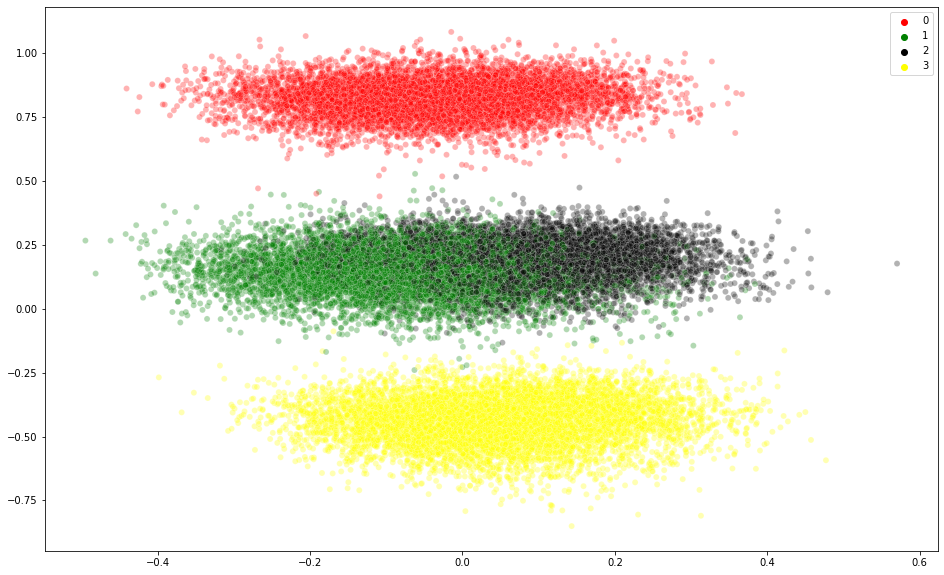

In [87]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X[:,0], y=X[:,1],
    hue=y,
    palette=['red', 'green', 'black', 'yellow'],
    legend="full",
    alpha=0.3
)

## Load and plot GMM model

In [68]:
# load torch checkpoint
model = torch.load("/mnt/gyzhang/fastspeech2-master/checkpoints/fs2_hiemo_fb0125_consp_m6/model_ckpt_steps_162000.ckpt")


In [69]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='diag')

In [73]:
# set mean
hi_mean = model['state_dict']['model.hi_mean.weight'].cpu()
gmm.means_ = hi_mean.numpy()

# set variance 
# hi_var = model['state_dict']['model.hi_var.weight'].cpu()
gmm.covariances_ = np.exp([[-6,-6],[-6,-6],[-6,-6],[-6,-6]])

gmm.weights_ = [0.25, 0.25, 0.25, 0.25]

In [80]:
gmm.means_

array([[ 0.02162547, -0.43388274],
       [-0.05456531,  0.12781057],
       [ 0.05071048,  0.1998708 ],
       [-0.06507186,  0.82293963]], dtype=float32)

In [75]:
gmm.covariances_

array([[0.00247875, 0.00247875],
       [0.00247875, 0.00247875],
       [0.00247875, 0.00247875],
       [0.00247875, 0.00247875]])

### GMM generator

In [78]:
X,y = gmm.sample(30000)


<AxesSubplot:>

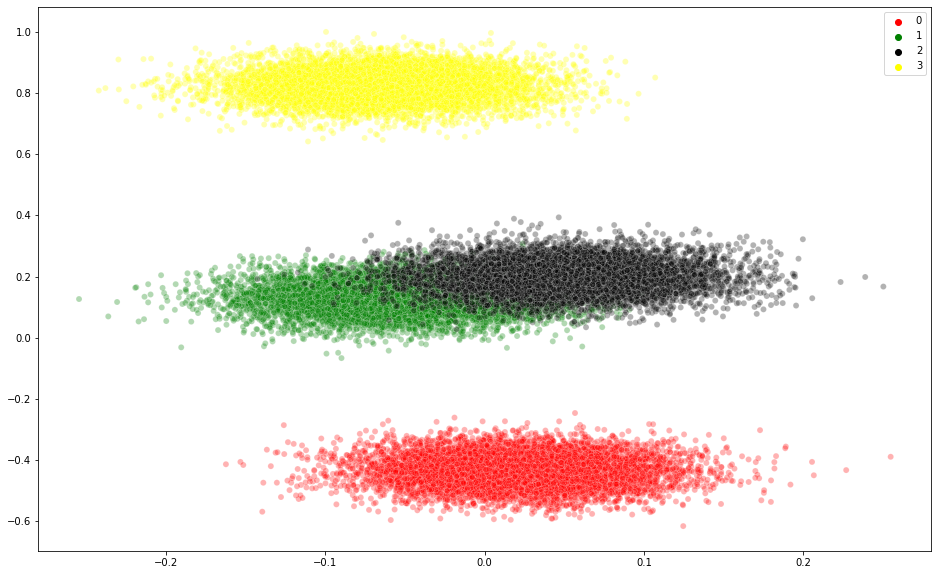

In [79]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X[:,0], y=X[:,1],
    hue=y,
    palette=['red', 'green', 'black', 'yellow'],
    legend="full",
    alpha=0.3
)

## MI calculation

In [3]:

train_files, test_files = train_test_split(file_list, test_size=0.2, shuffle=True)

train_list = []
for train_file in train_files:
    np_arr = np.load(train_file)
    
    train_list.append(np_arr)
train_mean = np.mean(train_list, axis=0)
train_std = np.std(train_list, axis=0)

In [9]:
N=32
N2=16
N3=8

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fcx = nn.Linear(2, N2)
        self.fcy = nn.Linear(61, N2)
        self.fc2 = nn.Linear(N2, N2)
        self.fc5 = nn.Linear(N2, 1)

    def forward(self, x, y):
        hx1 = F.relu(self.fcx(x))
        hy1 = F.relu(self.fcy(y))
        h1 = hx1 + hy1
        h2 = F.relu(self.fc2(h1))
        h2 = h1 + h2
        h5 = self.fc5(h2)
        return h5

In [10]:
class MyDataset(Dataset):
    def __init__(self, files):
        self.files = files
        random.seed(1234)
        random.shuffle(self.files)

    def load_data(self, file_path):
        spk, emo,_ = re.split("\_", os.path.basename(file_path))
        spk_id = spk2id[spk]
        np_arr = np.load(file_path)
        return np_arr, spk_id
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.load_data(self.files[idx])
    
    def collate_fn(self, batch):
        embeddings = np.stack([d[0] for d in batch])
        embeddings = (embeddings - train_mean) / train_std
        embeddings = torch.FloatTensor(embeddings)
        emos = [d[1] for d in batch] 
        emos_permutation = np.random.permutation(emos)
        emos = torch.FloatTensor(np.eye(len(spk_list) + 1)[emos])
        emos_permutation = torch.FloatTensor(np.eye(len(spk_list) + 1)[emos_permutation])
        return embeddings, emos, emos_permutation

In [11]:
train_dataset = MyDataset(files=train_files)
test_dataset = MyDataset(files=test_files)

train_loader = DataLoader(
            train_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=train_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)
test_loader = DataLoader(
            test_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=test_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)

model = Net().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
plot_loss = []

In [12]:
sw = SummaryWriter("/mnt/gyzhang/log-outdir/log_spk")


In [ ]:
n_epoch = 1000

for epoch in tqdm(range(n_epoch)):
    epoch_loss = []
    for train_batch in train_loader:
        x, y, y_permu = train_batch
        model.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        epoch_loss.append(-loss.cpu().data.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    sw.add_scalar('epoch_loss', torch.Tensor(np.array(np.mean(epoch_loss))), epoch + 1)
    model.eval()
    val_epoch_loss = []
    for test_batch in test_loader:
        x, y, y_permu = test_batch
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        val_epoch_loss.append(ret.cpu().data.item())
    sw.add_scalar('val_epoch_loss', torch.Tensor(np.array(np.mean(val_epoch_loss))), epoch + 1)
    model.train()

 34%|███▎      | 335/1000 [3:27:08<6:54:36, 37.41s/it]

In [4]:
import threading
import IPython.display as ipd
import numpy as np
from ipywidgets import widgets
from ipywidgets.widgets import Label, FloatProgress, FloatSlider
from ipywidgets.widgets import Layout, HBox, VBox
import bqplot as bq
from ipywidgets.widgets import Audio

## load fastspeech related packages
import sys
import torch
sys.path.insert(1, '/mnt/gyzhang/fastspeech2-master/')
from modules.fs2 import FastSpeech2
from tasks.fs2 import FastSpeech2Task,FastSpeechTestDataset
from utils.hparams import hparams, set_hparams

## load ganvocoder related packages
import os
import json
from ganvoc.env import AttrDict
from ganvoc.melgan_generator import MelGANGeneratorV1
from ganvoc.pqmf import PQMF
from ganvoc.dataset.meldataset import MAX_WAV_VALUE
from scipy import signal
from scipy.io.wavfile import write

## load matplot packages
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


**Load Gan Vocoder configuration**

In [5]:
v_checkpoint_file = "/mnt/shiqiang/share/ganvoc/model_emo/g_00680000"
config_file = os.path.join(os.path.split(v_checkpoint_file)[0], 'config.json')

global h
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
torch.manual_seed(h.seed)
global device
if torch.cuda.is_available():
    torch.cuda.manual_seed(h.seed)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

generator = MelGANGeneratorV1(
                out_channels=h.output_channel,
                channels=h.upsample_initial_channel,
                upsample_scales=h.upsample_rates,
                use_weight_norm=True,
                #stacks = 2,
            ).to(device)

state_dict_g = load_checkpoint(v_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

pqmf = PQMF(h.output_channel).to(device)

Loading '/mnt/shiqiang/share/ganvoc/model_emo/g_00680000'
Complete.


**Load configuration and corresponding checkpoint for the fastspeech2**

In [6]:
config_file = "/mnt/gyzhang/fastspeech2-master/configs/tts/TGEmotion/fs2_hiemo_fb0125_consp_m6.yaml"
exp_name = "fs2_hiemo_fb0125_consp_m6"
set_hparams(use_cmd=False, config=config_file, exp_name=exp_name)
hparams['data_dir'] = "/mnt/gyzhang/fastspeech2-master/data/tgemotion"
checkpoint_path = "./checkpoints/fs2_hiemo_fb0125_consp_m6/model_ckpt_steps_178000.ckpt"

In [7]:
hparams['save_latent']=False

In [8]:
task = FastSpeech2Task()
task.model = task.build_model()
test_dataset = FastSpeechTestDataset(hparams['data_dir'], task.phone_encoder,
                                                 hparams['test_set_name'], hparams, shuffle=False)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_dict = checkpoint['state_dict']
task.load_state_dict(model_dict)
task.cuda(0)
torch.cuda.empty_cache()
task.zero_grad()
task.eval()

| set hparams: 
accumulate_grad_batches: 1, arch: 8 8 8 8 8 8 8 8, attn_constraint: True, audio_num_mel_bins: 80, audio_sample_rate: 16000, 
base_config: configs/tts/fs2.yaml, check_val_every_n_epoch: 10, clip_grad_norm: 1, constant_prior_log_var: -6.0, copy_sync: False, 
data_dir: /mnt/gyzhang/fastspeech2-master/data/tgemotion, debug: False, dec_ffn_kernel_size: 9, dec_layers: 4, dict_file: dict, 
dropout: 0.2, dur_predictor_kernel: 3, enc_ffn_kernel_size: 9, enc_layers: 4, endless_ds: True, 
ffn_padding: SAME, fmax: 7600, fmin: 80, free_bits: 0.125, gen_dir_name: , 
gen_wav_denoise: False, griffin_lim_iters: 60, hi_dim: 2, hi_emo_enc_channels: [32, 32, 64, 64, 128, 128], hidden_size: 256, 
hierarchy_emo: True, hop_size: 160, indexed_ds: True, infer: False, keep_all_ckpts: True, 
lambda_dur: 1.0, lambda_energy: 1.0, lambda_pitch: 1.0, lambda_uv: 1.0, latent_size: 32, 
log_interval: 100, loud_norm: False, lr: 2.0, magnitude_power: 1, max_epochs: 1000, 
max_eval_sentences: 1, max_eval_t

FastSpeech2Task(
  (dur_loss_fn): DurationPredictorLoss(
    (criterion): MSELoss()
  )
  (mse_loss_fn): MSELoss()
  (model): FastSpeech2(
    (encoder_embed_tokens): Embedding(112, 256, padding_idx=0)
    (encoder): TransformerEncoder(
      (embed_tokens): Embedding(112, 256, padding_idx=0)
      (embed_positions): SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (op): EncSALayer(
            (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (self_attn): MultiheadAttention(
              (out_proj): Linear(in_features=256, out_features=256, bias=False)
            )
            (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (ffn): NewTransformerFFNLayer(
              (ffn_1): Conv1d(256, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
              (ffn_2): Linear(in_features=1024, out_features=256, bias=True)
            )
          )
        )
        (1):

In [11]:
idx=4
print(test_dataset[idx]['utt_id'])

TGE0135F_happy_124


In [12]:
input = test_dataset[idx]['source'].unsqueeze(0).cuda()
spk_embed = torch.IntTensor([test_dataset[idx]['spk_id']]).long().cuda()

In [13]:

emo_embed = torch.IntTensor([test_dataset[idx]['emo_id']]).long().cuda()

In [14]:
task.model = task.model.eval()

In [15]:
happy_mean = model_dict['model.hi_mean.weight'][2]

In [16]:
happy_log_var = torch.full(happy_mean.size(), hparams['constant_prior_log_var'])

In [17]:
happy_std = torch.exp(happy_log_var*0.5)

In [108]:
emo_embed = happy_mean + -0 * happy_std

emo_embed = emo_embed.cuda()
emo_embed = emo_embed.unsqueeze(0)

In [109]:
ret = task.model.text_audio_infer(
                input,  spk_embed=spk_embed, emo_embed=emo_embed)

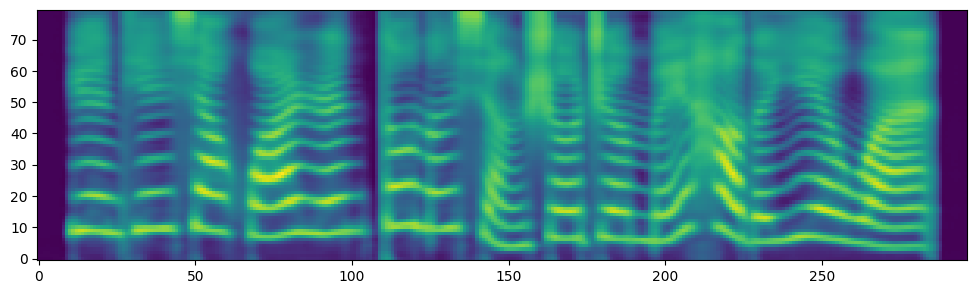

In [110]:
pred_mel = ret['text_mel_out']
pred_img = pred_mel.float().data.cpu().numpy()[0]
plt.imshow(pred_img.T,origin='lower', 
                       interpolation='none')

In [111]:
with torch.no_grad():
    x = ret['text_mel_out'].transpose(1,2).float().detach()
#     x = torch.FloatTensor(x).to(device)
    y_g_hat = generator(x)
    y_mb_ = y_g_hat
    y_g_hat = pqmf.synthesis(y_mb_)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.cpu().numpy()
    audio = signal.lfilter([1], [1, -0.85], audio).astype('int16')

In [112]:
ipd.Audio(data=audio,rate=16000)